# ITKVkFFT Python Demonstration

This example is derived from the "Compute Forward FFT" ITK Sphinx example at https://itk.org/ITKExamples/src/Filtering/FFT/ComputeForwardFFT/Documentation.html to demonstrate FFT performance speedup with `itk-vkfft`.

In [ ]:
import sys
!{sys.executable} -m pip install itk-vkfft matplotlib

In [2]:
import os
import time
from urllib.request import urlretrieve

import itk
import numpy as np
import matplotlib.pyplot as plt

img_args = {'aspect':'auto','interpolation':'none', 'origin':'lower'}

# Verify that ITKVkFFTBackend is installed
assert 'VkForwardFFTImageFilter' in dir(itk)

## FFT Applied to Downsampled MRI Volume

Here we perform an FFT operation on a small MRI 3D volume and visualize the modulus of the complex pixel results.

We compare FFT runtime between the default `vnl` math library backend, which runs on CPU, and the accelerated `vkfft` backend, which attempts to load and run on an OpenCL system library. For small datasets like this, running FFT on the CPU is typically more efficient than the added overhead of generating a GPU schedule with `vkfft`.

In [3]:
# Retrieve image for demo

IMAGE_PATH = 'data/HeadMRVolume.mha'

if not os.path.exists(IMAGE_PATH):
    os.makedirs('data',exist_ok=True)
    url = 'https://data.kitware.com/api/v1/file/5cad1a368d777f072b180d63/download'
    urlretrieve(url, IMAGE_PATH)

Retrieved image of size itkSize3 ([48, 62, 42])


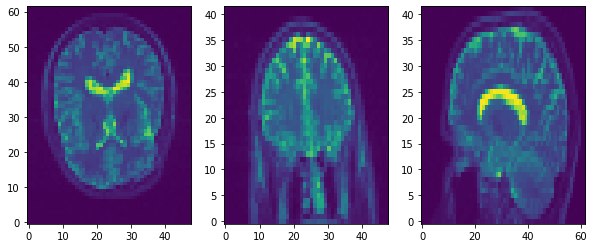

In [4]:
mri_image = itk.imread(IMAGE_PATH)
print(f'Retrieved image of size {itk.size(mri_image)}')

# Visualize a slice in each dimension
_, axs = plt.subplots(ncols=3,figsize=(10,4))

axs[0].imshow(mri_image[20,:,:],**img_args)
axs[1].imshow(mri_image[:,20,:],**img_args)
axs[2].imshow(mri_image[:,:,20],**img_args)

plt.show()

In [5]:
# Pad image for FFT
padded_image = itk.wrap_pad_image_filter(mri_image, pad_upper_bound=[0,2,6])
padded_image = itk.cast_image_filter(padded_image, ttype=[type(padded_image),itk.Image[itk.F,padded_image.GetImageDimension()]])

# Run FFT computation
t1 = time.time()
vnl_fft_image = itk.vnl_forward_fft_image_filter(padded_image)
t2 = time.time()
vk_fft_image = itk.vk_forward_fft_image_filter(padded_image)
t3 = time.time()

print(f'Vnl FFT took {(t2 - t1):0.3f} s to run')
print(f'Vk FFT took {(t3 - t2):0.3f} s to run')

Vnl FFT took 0.807 s to run
Vk FFT took 3.090 s to run


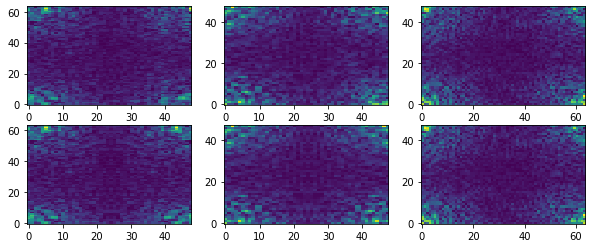

In [6]:
# Get real part for visualization
vnl_real_image = itk.complex_to_modulus_image_filter(vnl_fft_image)
vk_real_image = itk.complex_to_modulus_image_filter(vk_fft_image)

# Visualize a slice in each dimension
_, axs = plt.subplots(nrows=2,ncols=3,figsize=(10,4))

axs[0,0].imshow(vnl_real_image[10,:,:],**img_args)
axs[0,1].imshow(vnl_real_image[:,10,:],**img_args)
axs[0,2].imshow(vnl_real_image[:,:,10],**img_args)

axs[1,0].imshow(vk_real_image[10,:,:],**img_args)
axs[1,1].imshow(vk_real_image[:,10,:],**img_args)
axs[1,2].imshow(vk_real_image[:,:,10],**img_args)

plt.show()

## FFT Applied to Large, Random Volume

Here we perform an FFT operation on a large, random 3D volume and visualize the modulus of the complex pixel results.

We again compare FFT runtime between the `vnl` and `vkfft` backends. For larger datasets like this GPU acceleration with `vkfft` typically yields significant speedup.

In [7]:
rand_image = itk.image_from_array(np.random.rand(1000,1000,500))

In [8]:
# Pad image for FFT
padded_image = itk.wrap_pad_image_filter(rand_image)
padded_image = itk.cast_image_filter(padded_image, ttype=[type(padded_image),itk.Image[itk.F,padded_image.GetImageDimension()]])

# Run FFT computation
t1 = time.time()
vnl_fft_image = itk.vnl_forward_fft_image_filter(padded_image)
t2 = time.time()
vk_fft_image = itk.vk_forward_fft_image_filter(padded_image)
t3 = time.time()

print(f'Vnl FFT took {(t2 - t1):0.3f} s to run')
print(f'Vk FFT took {(t3 - t2):0.3f} s to run')

Vnl FFT took 25.031 s to run
Vk FFT took 8.635 s to run


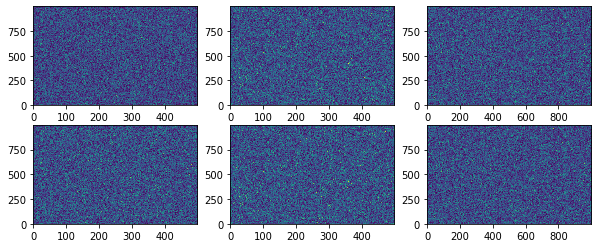

In [9]:
# Get real part for visualization
vnl_real_image = itk.complex_to_modulus_image_filter(vnl_fft_image)
vk_real_image = itk.complex_to_modulus_image_filter(vk_fft_image)

# Visualize a slice in each dimension
_, axs = plt.subplots(nrows=2,ncols=3,figsize=(10,4))

axs[0,0].imshow(vnl_real_image[10,:,:],**img_args)
axs[0,1].imshow(vnl_real_image[:,10,:],**img_args)
axs[0,2].imshow(vnl_real_image[:,:,10],**img_args)

axs[1,0].imshow(vk_real_image[10,:,:],**img_args)
axs[1,1].imshow(vk_real_image[:,10,:],**img_args)
axs[1,2].imshow(vk_real_image[:,:,10],**img_args)

plt.show()